# Customer Churn Prediction — Telco
----- 
**Objective:** Predict whether a customer will cancel their subscription.  
**Dataset:** [Telco Customer Churn — Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  
**Pipeline:**
1. Exploratory Data Analysis 
2. Preprocessing
3. Base Model — Logistic Regression
4. Advanced Model — XGBoost
5. Model Comparison


---
## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
)
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

sns.set_theme(style='darkgrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False

print('All libraries loaded successfully.')

All libraries loaded successfully.


---
## 2. Load Data

In [2]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f'Dimensions: {df.shape[0]:,} rows x {df.shape[1]} columns')
df.head()

Dimensions: 7,043 rows x 21 columns


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,3186-AJIEK,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [5]:
# Checking for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print('Missing values:')
print(missing_values if not missing_values.empty else 'None found')

Missing values:
None found


---
## 3. Analysis

### 3.1 Target Variable Distribution — Churn

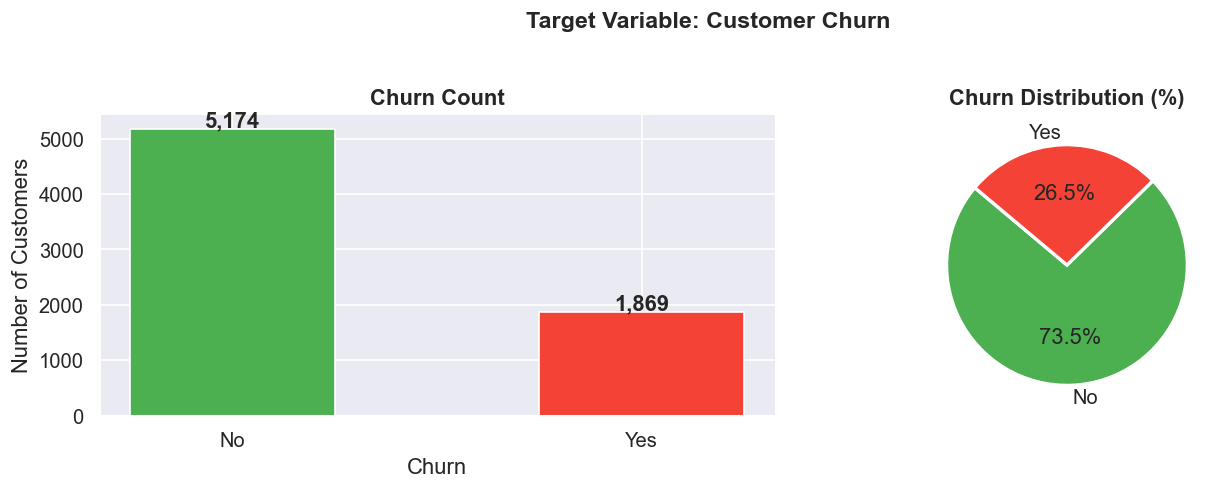

Churn Rate: 26.5%  |  Retention Rate: 73.5%


In [6]:
# Churn = A user who cancelled their subscription
# The Churn column is the Target variable we want to predict.
# Churn Value = No -> User keeps their subscription, Churn Value = Yes -> User cancelled their subscription
churn_count = df['Churn'].value_counts()
churn_pct    = df['Churn'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar Chart
bars = axes[0].bar(churn_count.index, churn_count.values, color=['#4CAF50', '#F44336'], edgecolor='white', width=0.5)
axes[0].set_title('Churn Count', fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Number of Customers')
for bar, val in zip(bars, churn_count.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{val:,}', ha='center', fontweight='bold')

# Pie Chart
axes[1].pie(churn_count.values, labels=churn_count.index, autopct='%1.1f%%', colors=['#4CAF50', '#F44336'], startangle=140, wedgeprops=dict(edgecolor='white', linewidth=2))
axes[1].set_title('Churn Distribution (%)', fontweight='bold')

plt.suptitle('Target Variable: Customer Churn', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Churn Rate: {churn_pct['Yes']:.1f}%  |  Retention Rate: {churn_pct['No']:.1f}%")

In [7]:
# The dataset is clearly imbalanced. This can affect the model training as it might learn shortcuts...

In [8]:
# ...such as: If I always predict "Retention", I will have an accuracy rate of 73.5%.

### 3.2 Numerical Variables — Distributions

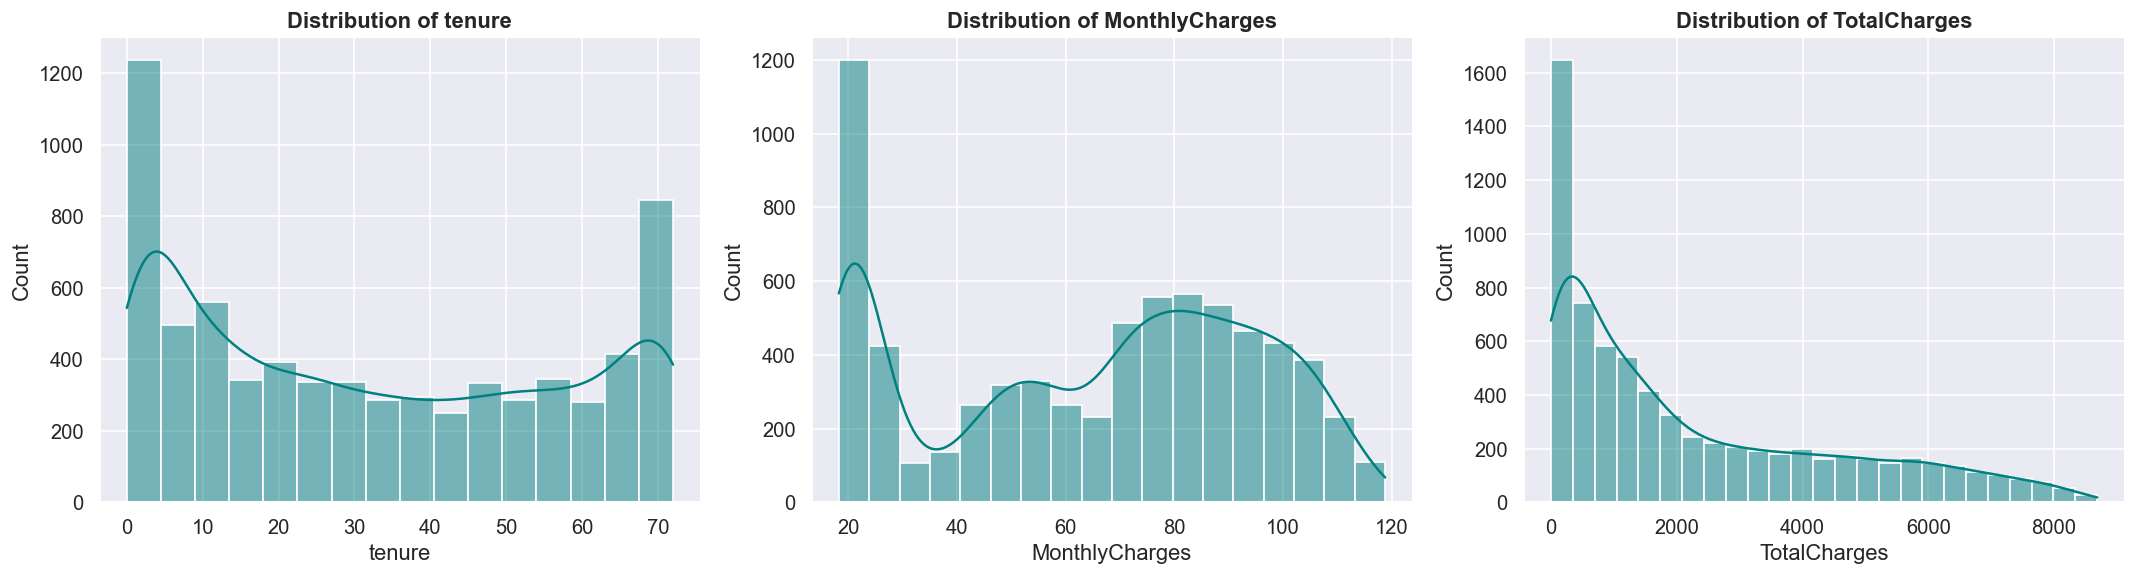

In [9]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Ensure TotalCharges is numeric, handling spaces as NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribution of {col}', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 4. Preprocessing

In [10]:
# 1. Drop customerID (not useful for prediction)
model_df = df.drop('customerID', axis=1)

# 2. Encode Binary Variables
le = LabelEncoder()
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    model_df[col] = le.fit_transform(model_df[col])

# 3. For columns with multiple categories, new columns are created for each option
model_df = pd.get_dummies(model_df)

print(f"Final dimensions after preprocessing: {model_df.shape}")
model_df.head()

Final dimensions after preprocessing: (7043, 41)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


In [11]:
# Split into X and y
X = model_df.drop('Churn', axis=1)
y = model_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---
## 5. Base Model — Logistic Regression

In [12]:
lr_model = LogisticRegression(max_iter=1000, random_state=SEED)
lr_model.fit(X_train_scaled, y_train)

lr_preds = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression - Classification Report:")
print(classification_report(y_test, lr_preds, target_names=['No Churn', 'Churn']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, lr_proba):.4f}")

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1035
       Churn       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC-AUC Score: 0.8418


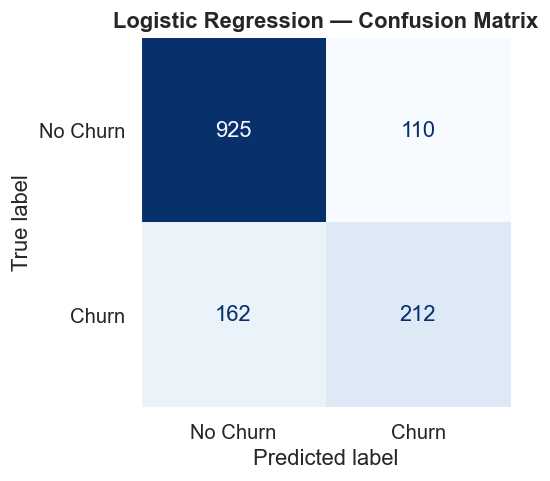

In [13]:
def plot_confusion_matrix(y_true, y_pred, title, ax, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
    disp.plot(ax=ax, cmap=cmap, colorbar=False)
    ax.grid(False)
    ax.set_title(title, fontweight='bold')

fig, ax = plt.subplots(figsize=(6, 4))
plot_confusion_matrix(y_test, lr_preds, 'Logistic Regression — Confusion Matrix', ax)
plt.show()

---
## 6. Advanced Model — XGBoost

In [14]:
# Balanced weight for class imbalance
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = XGBClassifier(
    scale_pos_weight=pos_weight, 
    eval_metric='auc', 
    random_state=SEED, 
    verbosity=0,
    use_label_encoder=False
)

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

search = RandomizedSearchCV(
    xgb_base, 
    param_distributions=param_grid, 
    n_iter=20, 
    scoring='roc_auc', 
    cv=StratifiedKFold(n_splits=5), 
    verbose=1, 
    random_state=SEED, 
    n_jobs=-1
)

search.fit(X_train, y_train)

print(f"Best Parameters: {search.best_params_}")
print(f"Best Cross-Val ROC-AUC: {search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best Cross-Val ROC-AUC: 0.8490


In [15]:
best_xgb = search.best_estimator_
xgb_preds = best_xgb.predict(X_test)
xgb_proba = best_xgb.predict_proba(X_test)[:, 1]

print("XGBoost - Classification Report:")
print(classification_report(y_test, xgb_preds, target_names=['No Churn', 'Churn']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, xgb_proba):.4f}")

XGBoost - Classification Report:
              precision    recall  f1-score   support

    No Churn       0.91      0.73      0.81      1035
       Churn       0.51      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.81      0.75      0.76      1409

ROC-AUC Score: 0.8470


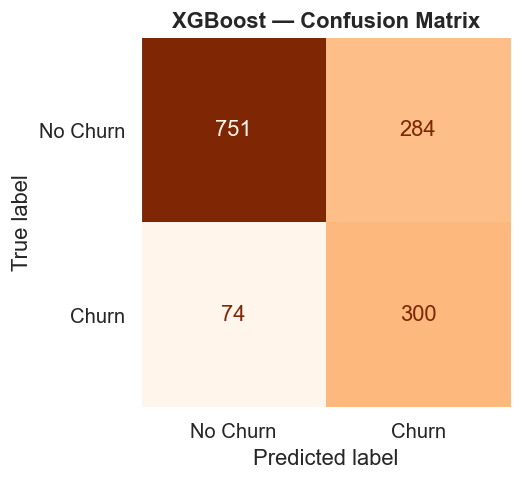

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_confusion_matrix(y_test, xgb_preds, 'XGBoost — Confusion Matrix', ax, cmap='Oranges')
plt.show()

---
## 7. Feature Importance

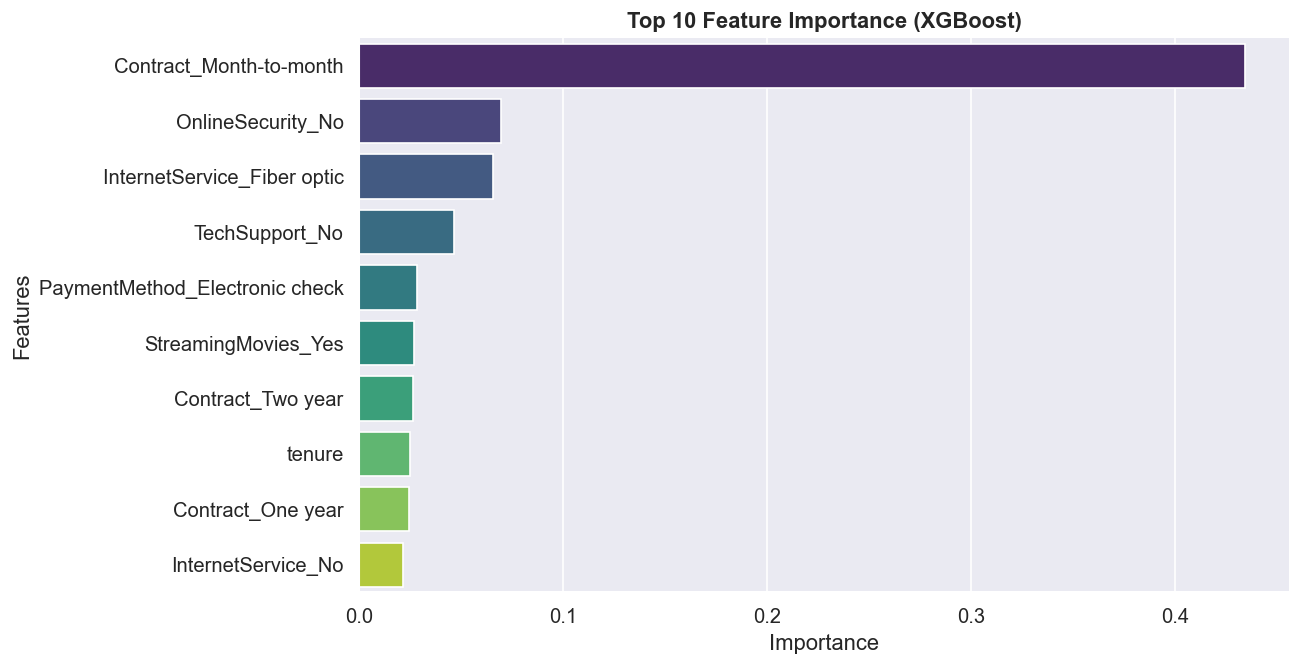

In [17]:
importances = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Top 10 Feature Importance (XGBoost)', fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

---
## 8. Summary and Conclusions

- **Model Performance:** Both models achieved a ROC-AUC score around 0.84-0.85, indicating good discriminatory power.
- **XGBoost Utility:** XGBoost was particularly useful in handling class imbalance through `scale_pos_weight` and yielded robust results.
- **Key Features:** Features related to Contract, Tenure, and Monthly Charges were among the most important for predicting customer churn.
- **Business Recommendations:** Targeted retention strategies could focus on customers with shorter tenure and certain contract types.